# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.535798,False,-3.887165
1,0.241690,True,4.956606
2,0.072863,True,2.843988
3,0.000518,True,4.802711
4,-1.340945,False,-4.026831
...,...,...,...
995,0.287928,False,-1.342023
996,-1.182559,False,-3.059115
997,-0.226997,False,-0.294755
998,-0.630083,False,-1.250803


<AxesSubplot: xlabel='v0'>

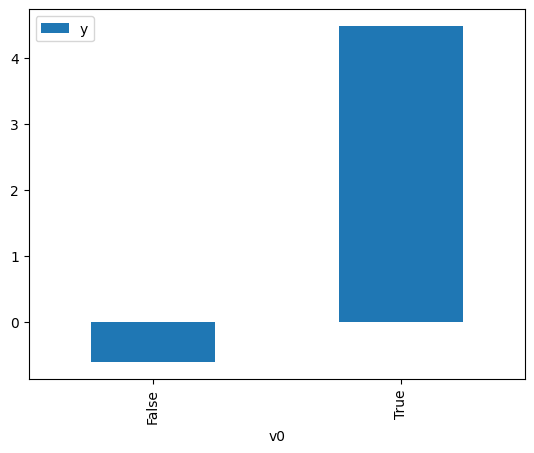

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

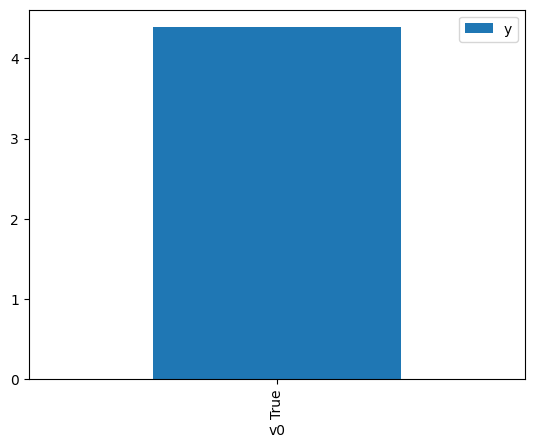

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.082695,False,4.060896,0.016085,62.169521
1,1.099656,False,3.199019,0.102838,9.723999
2,-0.411774,False,0.875990,0.696001,1.436779
3,-1.089992,False,-0.845814,0.897707,1.113950
4,-0.784026,False,-2.243816,0.827188,1.208915
...,...,...,...,...,...
995,-0.856869,False,-1.012128,0.846854,1.180840
996,-0.190172,False,0.471012,0.596114,1.677533
997,0.980997,False,2.424498,0.126641,7.896346
998,-0.107339,False,0.008385,0.556061,1.798364


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.464802,True,4.948393,0.282238,3.543110
1,1.113828,True,7.472993,0.899723,1.111453
2,-0.112546,True,4.683048,0.441394,2.265550
3,-1.384539,True,3.255545,0.059774,16.729639
4,0.811673,True,6.790507,0.831393,1.202800
...,...,...,...,...,...
995,-0.423827,True,4.328345,0.298970,3.344822
996,-0.126695,True,5.548011,0.434494,2.301526
997,-0.798977,True,2.545487,0.168619,5.930530
998,-0.084513,True,5.623516,0.455129,2.197180


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              8857.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:31:42   Log-Likelihood:                         -1415.2
No. Observations:                1000   AIC:                                      2834.
Df Residuals:                     998   BIC:                                      2844.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2562      0.029     77.067      0.000       2.199       2.314
x2             4.9710      0.053     93.536      0.000       4.867       5.075
==============================================================================
Omnibus:                        0.954   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.621   Jarque-Bera (JB):                0.827
Skew:                          -0.023   Prob(JB):                        0.661
Kurtosis:                       3.133   Cond. No.                         1.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""